#### Задание

Используя данные из обучающего датасета `train.csv`, построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели, предсказать цены для квартир из тестового датасета `test.csv`.

Целевая переменная: `Price`

Метрика качества: `R2` - коэффициент детерминации (`sklearn.metrics.r2_score`)

#### Требования к решению

1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin_predictions.csv. Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).


In [683]:
import warnings
warnings.filterwarnings('ignore')

In [684]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [685]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'ShadrinAA_predictions.csv'

In [686]:
# Функция преобразования каитегориальных переменных в булевые, если они принимают только два значения.
def obj_to_bool (columns, df):
    for column in columns:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

In [687]:
# Функция для отображения scatter-графика по двум признакам.
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()  

In [688]:
# Функция вырезает из выборки выбросы.
def drop_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format(column, IQ, low_border, high_border))
    
    size_before = df[column].size
    df.drop(df[(df[column]<low_border)|(df[column]>high_border)].index, axis=0, inplace=True)    
    size_after = df[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

In [689]:
# Функция заменяет выбросы в выборке на среднее значение по признаку.
def replace_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    mean = df[column].mean()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, mean))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = mean
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, mean))

In [690]:
# Функция заполняет пустые значения признака LifeSquare, высчитывая его через общую площадь квартиры.
def fill_life_square(df, coeff):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * coeff

In [691]:
# Функция заменяет выбросы признака HouseYear средним значением.
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [692]:
# Функция считает метрику r2_score и mae по переданным наборам данных и модели.
def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')

In [693]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [694]:
df_test = pd.read_csv(TEST_DATASET_PATH)

#### Описание датасета

```
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры 
```

In [695]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


Датасет содержит три категориальных признака (`Ecology_2`, `Ecology_3`, `Shops_2`). По двум признакам есть пропущенные значения (`LifeSquare`, `Healthcare_1`). 

Сперва избавимся от категориальных признаков.

In [696]:
obj_features = df.select_dtypes(include='object').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

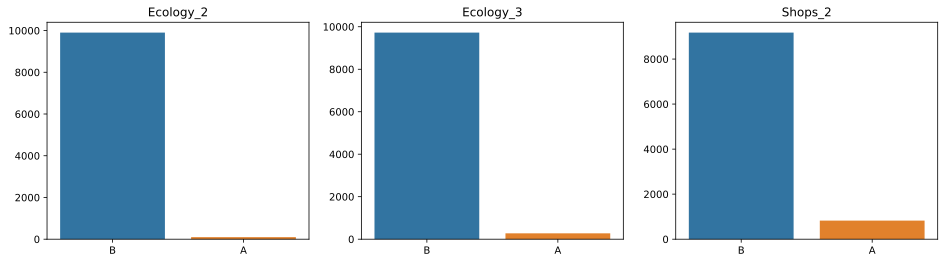

In [697]:
plt.figure(figsize = (16,4))

for i, colname in enumerate(obj_features):
    counts = df[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

In [698]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



Так как признаки принимают всего два значения, заменим их на бинарные признаки.

In [699]:
obj_to_bool(obj_features, df)

In [700]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

False    9903
True       97
Name: Ecology_2, dtype: int64

False    9725
True      275
Name: Ecology_3, dtype: int64

False    9175
True      825
Name: Shops_2, dtype: int64



Количество значений не изменилось, значит преобразование сделано правильно.

Признак `Healthcare_1` содержит очень много пропущенных значений. Не будем учитывать этот признак в процессе анализа.

In [701]:
 df.drop(['Healthcare_1'], axis=1, inplace=True)

Исследуем значения признаков `LifeSquare` и `Square`. Попробуем установить зависимость между жилой площадью и полной площадью квартиры.

In [702]:
df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [703]:
df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

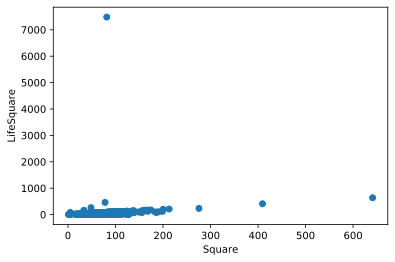

In [704]:
draw_scatter('Square', 'LifeSquare', df)

Оба признака имеют выбросы. Избавимся от них.

In [705]:
drop_by_IQ('Square', df)

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728

Lost 2.42% of data.


In [706]:
drop_by_IQ('LifeSquare', df)

For column LifeSquare
	IQ:	21.75692564475336
	LOW:	-9.940131635100535
	HIGH:	77.08757094391291

Lost 1.91% of data.


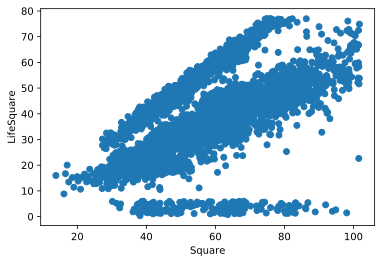

In [707]:
draw_scatter('Square', 'LifeSquare', df)

Наблюдения можно было бы разделить на три класса и построить модель для каждого класса. Но я этого делать не буду, так как выполняю курсовой проект в последний день.

Найдём долю жилой площади от общей по сроедним значениям в выборке и заполним пропущенные значения в столбце LifeSquare.

In [708]:
square_mean_values = df[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6378520569631749

In [709]:
fill_life_square(df, square_coeff)

Ещё раз взгляним ни получившийся датасет.

In [710]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 0 to 9999
Data columns (total 19 columns):
Id               9572 non-null int64
DistrictId       9572 non-null int64
Rooms            9572 non-null float64
Square           9572 non-null float64
LifeSquare       9572 non-null float64
KitchenSquare    9572 non-null float64
Floor            9572 non-null int64
HouseFloor       9572 non-null float64
HouseYear        9572 non-null int64
Ecology_1        9572 non-null float64
Ecology_2        9572 non-null bool
Ecology_3        9572 non-null bool
Social_1         9572 non-null int64
Social_2         9572 non-null int64
Social_3         9572 non-null int64
Helthcare_2      9572 non-null int64
Shops_1          9572 non-null int64
Shops_2          9572 non-null bool
Price            9572 non-null float64
dtypes: bool(3), float64(7), int64(9)
memory usage: 1.6 MB


In [711]:
df.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean    8382.207376    50.579816     1.845905    54.118859    34.519826   
std     4856.596405    43.768356     0.809624    15.594497    13.030713   
min        2.000000     0.000000     0.000000    13.784865     0.370619   
25%     4169.500000    19.000000     1.000000    41.537091    24.065821   
50%     8390.500000    36.000000     2.000000    51.217517    32.871722   
75%    12591.250000    77.000000     2.000000    64.293638    43.319537   
max    16798.000000   209.000000    19.000000   102.032801    77.052978   

       KitchenSquare        Floor   HouseFloor     HouseYear    Ecology_1  \
count    9572.000000  9572.000000  9572.000000  9.572000e+03  9572.000000   
mean        6.243105     8.471061    12.586293  4.079251e+03     0.119942   
std        29.065509     5.168552     6.628252  2.049338e+05     0.119592   
min         0.000000     1.000000     0.000000  1.910000e+03     0.000000   
25%         1.000000     4.000000     9.000000  1.973000e+03     0.017647   
50%         6.000000     7.000000    12.000000  1.977000e+03     0.075779   
75%         9.000000    12.000000    17.000000  1.999000e+03     0.195781   
max      2014.000000    42.000000   117.000000  2.005201e+07     0.521867   

          Social_1      Social_2     Social_3  Helthcare_2      Shops_1  \
count  9572.000000   9572.000000  9572.000000  9572.000000  9572.000000   
mean     24.914333   5390.685959     8.029461     1.327518     4.237986   
std      17.488685   3994.347092    23.702448     1.485634     4.792616   
min       0.000000    168.000000     0.000000     0.000000     0.000000   
25%       6.000000   1564.000000     0.000000     0.000000     1.000000   
50%      25.000000   5285.000000     2.000000     1.000000     3.000000   
75%      36.000000   7287.000000     5.000000     2.000000     6.000000   
max      74.000000  19083.000000   141.000000     6.000000    23.000000   

               Price  
count    9572.000000  
mean   209182.371820  
std     87271.970772  
min     59174.778028  
25%    151904.418474  
50%    189610.138453  
75%    244221.524382  
max    633233.466570

Признак `KitchenSquare` содержит выбросы. Избавимся от них.

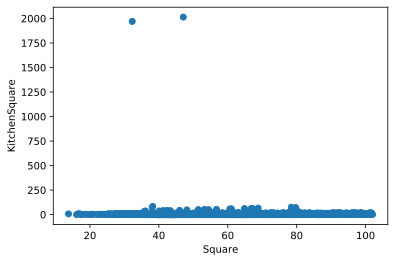

In [712]:
draw_scatter('Square', 'KitchenSquare', df)

In [713]:
replace_by_IQ('KitchenSquare', df)

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.2431048892603425
In 31 row KitchenSquare was replaced to 6.2431048892603425.


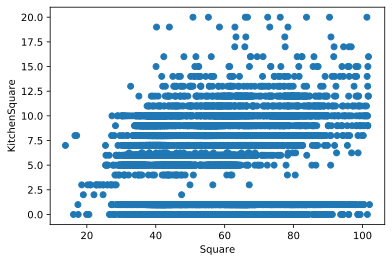

In [714]:
draw_scatter('Square', 'KitchenSquare', df)

Признак HouseYear так же содержит выпадающие значения. Обработаем их.

In [715]:
mean_year = np.round(df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1984.0

In [716]:
clean_year(df, mean_year)

Ещё раз взглянем на получившийся датасет.

In [717]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id', 'DistrictId'], axis=1)

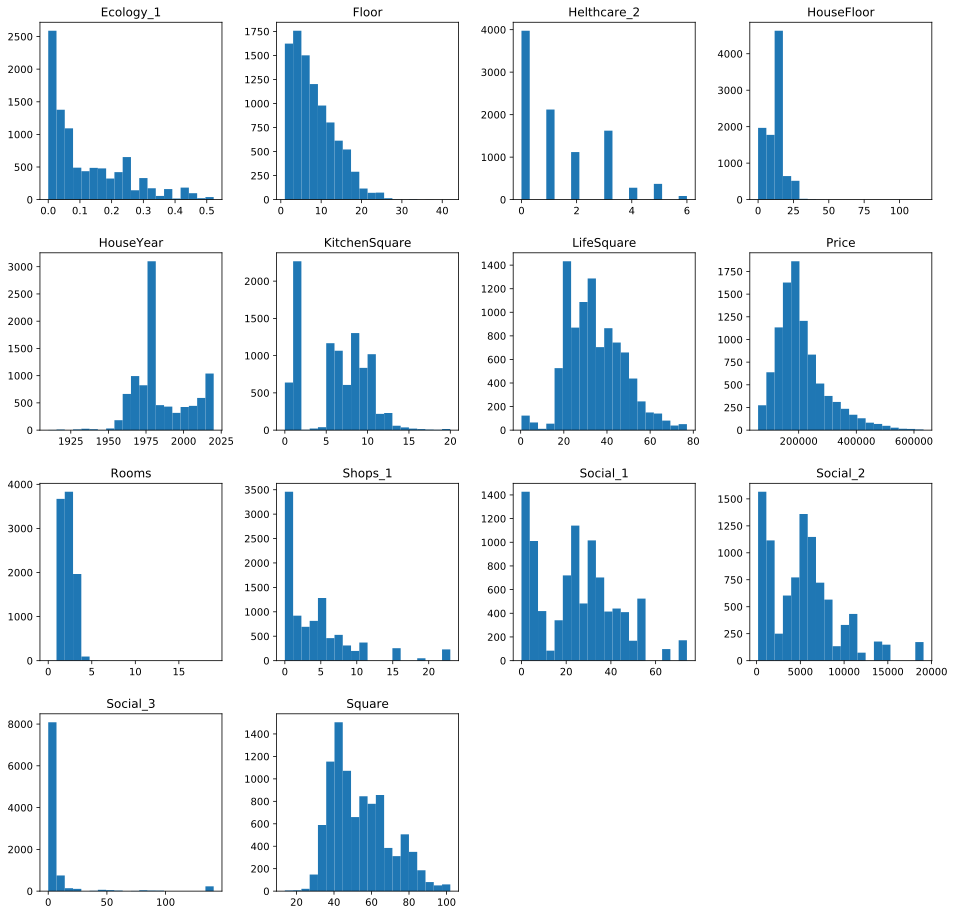

In [718]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [719]:
# sns.pairplot(df_num_features);

Выбросов нет. В процессе подготовки данных мы заменили категориальные признаки на бинарные. Исключили из анализа признак `Healthcare_1`. Исключили выбросы из выборки по признакам `Square` и `LifeSquare`. Заменили выбросы по признаку `KitchenSquare` на средние значения. И заполнили пропущенные значения по признаку `LifeSquare`. Сделаем то же самое для тестового датафрейма. Однако, вместо исключения выбросов по признакам `Square` и `LifeSquare` заменим выбросы на средние значения.

In [720]:
test = pd.read_csv(TEST_DATASET_PATH)
obj_to_bool(obj_features, test)
test.drop(['Healthcare_1'], axis=1, inplace=True)
replace_by_IQ('Square', test)
replace_by_IQ('LifeSquare', test)
fill_life_square(test, square_coeff)
replace_by_IQ('KitchenSquare', test)

For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048
	MEAN:	56.449500363812504
In 110 row Square was replaced to 56.449500363812504.
For column LifeSquare
	IQ:	22.082065205778463
	LOW:	-10.031071759483922
	HIGH:	78.29718906362993
	MEAN:	36.158810455086694
In 118 row LifeSquare was replaced to 36.158810455086694.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.9768
In 19 row KitchenSquare was replaced to 5.9768.


Разобьем тестовый датасет на тестовый и валидационный.

In [721]:
features = df.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'

In [722]:
X = pd.DataFrame(df, columns=features)
y = pd.DataFrame(df, columns=[target])

In [723]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [724]:
X_test = test[features]
X_test.head()

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    2.0  49.882643   33.432782            6.0      6        14.0       1972   
1    2.0  69.263183   44.179664            1.0      6         1.0       1977   
2    1.0  13.597819   15.948246           12.0      2         5.0       1909   
3    2.0  73.046609   51.940842            9.0     22        22.0       2007   
4    1.0  47.527111   43.387569            1.0     17        17.0       2017   

   Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  Helthcare_2  \
0   0.310199      False      False        11      2748         1            0   
1   0.075779      False      False         6      1437         3            0   
2   0.000000      False      False        30      7538        87            5   
3   0.101872      False      False        23      4583         3            3   
4   0.072158      False      False         2       629         1            0   

   Shops_1  Shops_2  
0        0    False  
1        2    False  
2        5    False  
3        3    False  
4        0     True

Масштабируем данные.

In [725]:
scaler = StandardScaler()

In [726]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

На тренировочном наборе модели `LinearRegression`, `Lasso` и `Ridge` дали примерно одинаковый результат `r2+score = 0.5`. Наилучший результат был получен на модели `RandomForestRegressor` с параметрами `n_estimators=1000, max_depth=9, max_features=7, random_state=42`.

In [727]:
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

r2_train = 0.8176997700702279, mae_train: 24437.630986260127
r2_test = 0.6800388539920708, mae_test: 30088.92504269905


Предсказываем цены для тестового датасета и выгружаем результат в файл. На сайте kaggle.com результат 0.688.

In [728]:
price = model.predict(X_test_scaled)
pd.DataFrame({ 'Id': test['Id'], 'Price': price }).to_csv(TEST_DATASET_EXT_PATH, index=False)